In [3]:
%pip -q install -r FastSAM/requirements.txt
%pip -q install git+https://github.com/openai/CLIP.git

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import cv2
import torch
import base64

import supervision as sv
import numpy as np
from jupyter_bbox_widget import BBoxWidget

from FastSAM.fastsam import FastSAM, FastSAMPrompt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [2]:
import os
HOME_PATH = os.getcwd()
FAST_SAM_CHECKPOINT_PATH = f"{HOME_PATH}/weights/FastSAM.pt"

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"DEVICE = {DEVICE}")
fast_sam = FastSAM(FAST_SAM_CHECKPOINT_PATH)

DEVICE = cpu


In [4]:
IMAGE_PATH = os.path.join(HOME_PATH, "images", "CASIA-Iris-Thousand","000","R","S5000R00.jpg")

results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.4,
    iou=0.9)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.everything_prompt()
print(masks)


image 1/1 d:\mc\py\nectecproj\SAM-iris-nectec\images\CASIA-Iris-Thousand\000\R\S5000R00.jpg: 768x1024 3 objects, 2120.7ms
Speed: 18.0ms preprocess, 2120.7ms inference, 37.0ms postprocess per image at shape (1, 3, 1024, 1024)


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [5]:
def masks_to_bool(masks):
    if type(masks) == np.ndarray:
        return masks.astype(bool)
    return masks.cpu().numpy().astype(bool)

def annotate_image(image_path: str, masks: np.ndarray) -> np.ndarray:
    image = cv2.imread(image_path)

    xyxy = sv.mask_to_xyxy(masks=masks)
    detections = sv.Detections(xyxy=xyxy, mask=masks)

    mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
    return mask_annotator.annotate(scene=image.copy(), detections=detections)

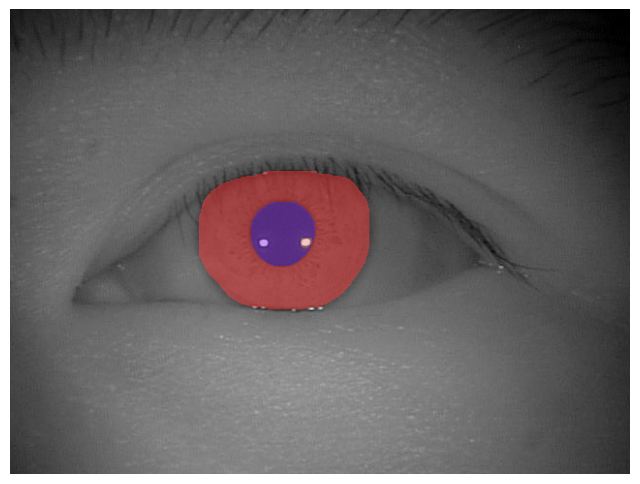

In [6]:
masks = masks_to_bool(masks)
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

In [7]:
print(masks.shape)

(3, 480, 640)


# Prompt

In [8]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [9]:
from jupyter_bbox_widget import BBoxWidget

image = os.path.join(HOME_PATH, "images", "CASIA-Iris-Thousand","000","R","S5000R00.jpg")
img = cv2.imread(image)

widget = BBoxWidget()
widget.image = encode_image(image)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [10]:
import numpy as np

def widgetToBox(box):
  return np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
  ])


iris_box = [widgetToBox(i) for i in widget.bboxes]
print(iris_box)

[array([181, 139, 379, 327]), array([249, 196, 326, 257])]


In [11]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.box_prompt(bboxes=iris_box)
print(masks.shape)

image 1/1 d:\mc\py\nectecproj\SAM-iris-nectec\images\CASIA-Iris-Thousand\000\R\S5000R00.jpg: 768x1024 2 objects, 2256.4ms
Speed: 10.0ms preprocess, 2256.4ms inference, 5.0ms postprocess per image at shape (1, 3, 1024, 1024)


(2, 480, 640)


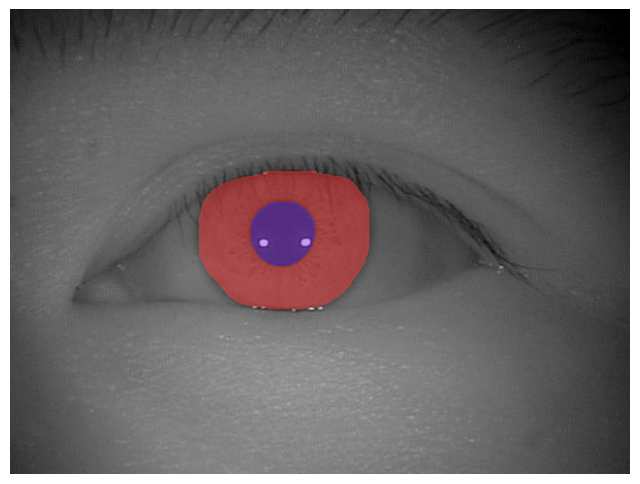

In [12]:
masks = masks_to_bool(masks)
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

In [14]:
import supervision as sv

def showAnnotator_FASTSAM(masks,ann_mode="bbox"):
  if ann_mode == "bbox": annotator = sv.BoundingBoxAnnotator(color=sv.Color.RED,color_lookup=sv.ColorLookup.INDEX)
  elif ann_mode == "circle": annotator = sv.CircleAnnotator(color=sv.Color.RED,color_lookup=sv.ColorLookup.INDEX)
  
  detections = sv.Detections(
      xyxy=sv.mask_to_xyxy(masks=masks),
      mask=masks
  )
  
  mask_img=annotator.annotate(scene=img.copy(), detections=detections)
  sv.plot_image(image=mask_img)

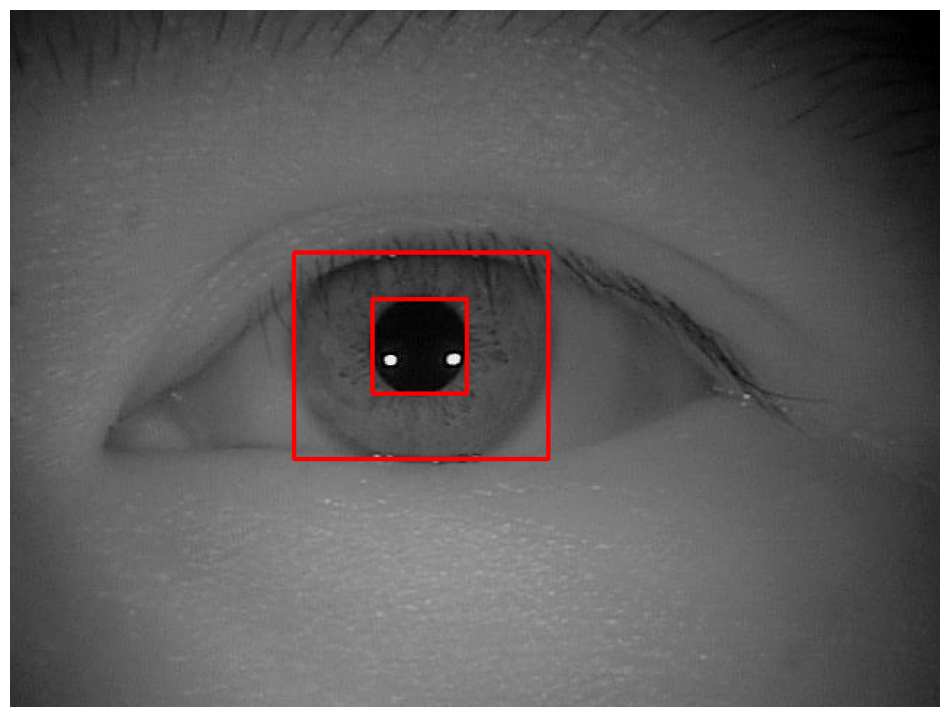

In [15]:
showAnnotator_FASTSAM(masks)